   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.4 MB/s eta 0:00:00
Original Sample Rate: 22050
Waveform Shape: torch.Size([1, 99229])
Processed Sample Rate: 16000
Audio Duration (sec): 4.5001875


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Recognized Phoneme-like Tokens:
MADE CERTAIN RECOMMENDATIONS WHICH IT BELIEVES WOULD IF ADOPTED

Estimated Time per Token (sec): 0.020090122767857144

Extracted Phoneme: RECOMMENDATIONS
Start Time (sec): 0.04
End Time (sec): 0.06
Saved extracted phoneme as: extracted_phoneme_RECOMMENDATIONS.wav


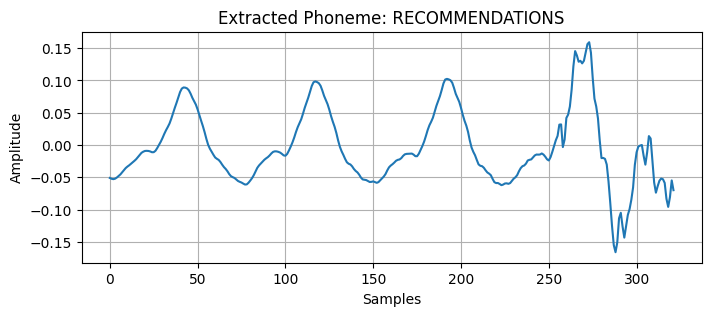

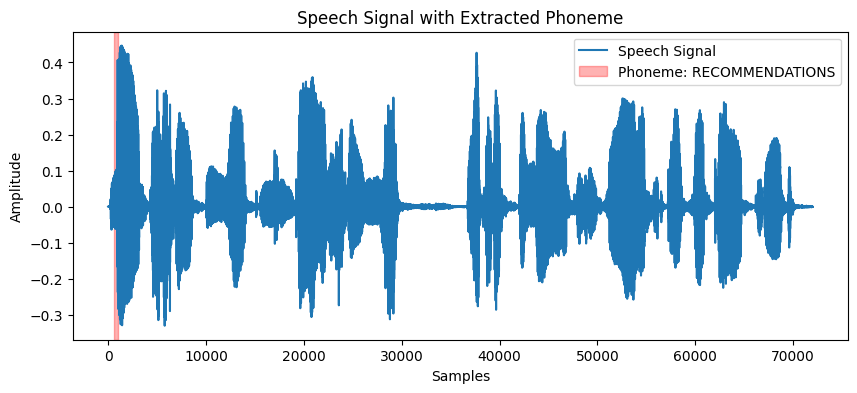


Inference about Sound Source:
The extracted phoneme is likely a CONSONANT or UNVOICED sound.


In [2]:
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC


try:
    import torchcodec
except ImportError:
    !pip install torchcodec


audio_path = "/content/LJ050-0274.wav"

waveform, sample_rate = torchaudio.load(audio_path)

print("Original Sample Rate:", sample_rate)
print("Waveform Shape:", waveform.shape)


if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

target_sr = 16000
if sample_rate != target_sr:
    resampler = torchaudio.transforms.Resample(sample_rate, target_sr)
    waveform = resampler(waveform)

sample_rate = target_sr
speech = waveform.squeeze().numpy()

duration = len(speech) / sample_rate
print("Processed Sample Rate:", sample_rate)
print("Audio Duration (sec):", duration)


processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-base-960h"
)
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h"
)
model.eval()


inputs = processor(
    speech,
    sampling_rate=16000,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    logits = model(inputs.input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)
recognized_tokens = processor.decode(predicted_ids[0])

print("\nRecognized Phoneme-like Tokens:")
print(recognized_tokens)


time_steps = logits.shape[1]
time_per_step = duration / time_steps

print("\nEstimated Time per Token (sec):", time_per_step)


tokens = recognized_tokens.split()
phoneme_index = 2
phoneme_label = tokens[phoneme_index]

start_time = phoneme_index * time_per_step
end_time = start_time + time_per_step

start_sample = int(start_time * sample_rate)
end_sample = int(end_time * sample_rate)

phoneme_signal = speech[start_sample:end_sample]

print("\nExtracted Phoneme:", phoneme_label)
print("Start Time (sec):", round(start_time, 3))
print("End Time (sec):", round(end_time, 3))


output_file = f"extracted_phoneme_{phoneme_label}.wav"

torchaudio.save(
    output_file,
    torch.tensor(phoneme_signal).unsqueeze(0),
    sample_rate
)

print("Saved extracted phoneme as:", output_file)


plt.figure(figsize=(8, 3))
plt.plot(phoneme_signal)
plt.title(f"Extracted Phoneme: {phoneme_label}")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(speech, label="Speech Signal")
plt.axvspan(
    start_sample,
    end_sample,
    color="red",
    alpha=0.3,
    label=f"Phoneme: {phoneme_label}"
)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Speech Signal with Extracted Phoneme")
plt.legend()
plt.show()


print("\nInference about Sound Source:")
vowels = ["AA", "AE", "AH", "AO", "EH", "IH", "IY", "UH", "UW"]

if phoneme_label.upper() in vowels:
    print("The extracted phoneme is a VOICED sound (Vowel).")
else:
    print("The extracted phoneme is likely a CONSONANT or UNVOICED sound.")